<a href="https://colab.research.google.com/github/melissaa06/Four_Real_Productions/blob/main/Four_Real_Productions_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import sklearn
from sklearn import datasets
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark


# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,635 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,396 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

In [ ]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

# Set the partitions to 4 or 8.
spark.conf.set("spark.sql.shuffle.partitions", 8)

# **Importing and Analyzing Dataset**

In [ ]:
# import raw github csv and show df

from pyspark import SparkFiles
url ="https://raw.githubusercontent.com/melissaa06/Four_Real_Productions/main/Movie_Data_Set_Project_4.csv"
spark.sparkContext.addFile(url)
movies_df = spark.read.csv(SparkFiles.get("Movie_Data_Set_Project_4.csv"), header=True, inferSchema=True)
movies_df.show()


+--------------------+-------------+------------+---------------+--------+----------------+------------------+-------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|          Budget|           Revenue|Runtime|
+--------------------+-------------+------------+---------------+--------+----------------+------------------+-------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|$250,000,000.00 |  $835,000,000.00 |    162|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| $90,000,000.00 |  $369,105,725.00 |    103|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|               -|    $4,495,365.00 |    101|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| $12,000,000.00 |  $158,000,000.00 |    102|
|         Transfusion|        MA15+|      1/5/23|          Crime| English|               -|                 -|    105|
|Detective Knight:...|            R|     1/20/23

# **Data Cleaning,remove dollar signs and the commas**

In [ ]:
#Import function
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_replace, col

#Change - to 0 in the reveunue column
update_func = (F.when(F.col('revenue') == '-', '0')
                .otherwise(F.col('revenue')))
movies_df = movies_df.withColumn('Revenue', update_func)

# Remove the dollar sign from the 'revenue' column
movies_df = movies_df.withColumn("Revenue", regexp_replace(col("Revenue"), "\\$", ""))

# Remove the comma from the 'revenue' column
movies_df = movies_df.withColumn("Revenue", regexp_replace(col("Revenue"), ",", ""))

#Change - to 0 in the budget column
update_func = (F.when(F.col('Budget') == '-', '0')
                .otherwise(F.col('Budget')))
movies_df = movies_df.withColumn('Budget', update_func)

# Remove the dollar sign from the 'budget' column
movies_df = movies_df.withColumn("Budget", regexp_replace(col("Budget"), "\\$", ""))

# Remove the comma from the 'budgt' column
movies_df = movies_df.withColumn("Budget", regexp_replace(col("Budget"), ",", ""))
movies_df.show()

+--------------------+-------------+------------+---------------+--------+-------------+--------------+-------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|       Budget|       Revenue|Runtime|
+--------------------+-------------+------------+---------------+--------+-------------+--------------+-------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|250000000.00 | 835000000.00 |    162|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| 90000000.00 | 369105725.00 |    103|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|            0|   4495365.00 |    101|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| 12000000.00 | 158000000.00 |    102|
|         Transfusion|        MA15+|      1/5/23|          Crime| English|            0|             0|    105|
|Detective Knight:...|            R|     1/20/23|         Action| English|            0|             0| 

In [ ]:

#Update dtypes to number
movies_df = movies_df.withColumn("Revenue", col("Revenue").cast("long"))
movies_df = movies_df.withColumn("Budget", col("Budget").cast("long"))
movies_df.show()

+--------------------+-------------+------------+---------------+--------+---------+----------+-------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|   Budget|   Revenue|Runtime|
+--------------------+-------------+------------+---------------+--------+---------+----------+-------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|250000000| 835000000|    162|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| 90000000| 369105725|    103|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|        0|   4495365|    101|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| 12000000| 158000000|    102|
|         Transfusion|        MA15+|      1/5/23|          Crime| English|        0|         0|    105|
|Detective Knight:...|            R|     1/20/23|         Action| English|        0|         0|     92|
|              JUNG_E|         PG13|     1/20/23|Science Fiction

In [ ]:
#Change NULL values in Budget to 0
movies_df = movies_df.na.fill(0)
movies_df.show()

+--------------------+-------------+------------+---------------+--------+---------+----------+-------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|   Budget|   Revenue|Runtime|
+--------------------+-------------+------------+---------------+--------+---------+----------+-------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|250000000| 835000000|    162|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| 90000000| 369105725|    103|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|        0|   4495365|    101|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| 12000000| 158000000|    102|
|         Transfusion|        MA15+|      1/5/23|          Crime| English|        0|         0|    105|
|Detective Knight:...|            R|     1/20/23|         Action| English|        0|         0|     92|
|              JUNG_E|         PG13|     1/20/23|Science Fiction

# **We created a new column 'profit' that is the difference between 'revenue' and budget**

In [ ]:
# Add a new column 'profit' that is the difference between 'revenue' and 'budget'
movies_df = movies_df.withColumn("Profit", col("Revenue") - col("Budget"))
movies_df = movies_df.withColumn("Percentage_Profit", ((col("Revenue") - col("Budget"))/col("Budget")))
movies_df.show()

+--------------------+-------------+------------+---------------+--------+---------+----------+-------+----------+-------------------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|   Budget|   Revenue|Runtime|    Profit|  Percentage_Profit|
+--------------------+-------------+------------+---------------+--------+---------+----------+-------+----------+-------------------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|250000000| 835000000|    162| 585000000|               2.34|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| 90000000| 369105725|    103| 279105725| 3.1011747222222223|
|     Shotgun Wedding|            R|    12/28/22|         Action| English|        0|   4495365|    101|   4495365|               NULL|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| 12000000| 158000000|    102| 146000000| 12.166666666666666|
|         Transfusion|        MA15+|      1/5/23|      

# **Remove all null values to improve machine learning analysis**

In [ ]:
#drop NULL values from movies_df
movies_df = movies_df.na.drop()
movies_df.show()

+--------------------+-------------+------------+---------------+--------+---------+----------+-------+----------+-------------------+
|          Movie_Name|Certification|Release_Date|         Genres|Language|   Budget|   Revenue|Runtime|    Profit|  Percentage_Profit|
+--------------------+-------------+------------+---------------+--------+---------+----------+-------+----------+-------------------+
|Black Panther: Wa...|         PG13|    11/10/22|         Action| English|250000000| 835000000|    162| 585000000|               2.34|
|Puss in Boots: Th...|           PG|     12/8/22|      Animation| English| 90000000| 369105725|    103| 279105725| 3.1011747222222223|
|               M3GAN|         PG13|      1/5/23|Science Fiction| English| 12000000| 158000000|    102| 146000000| 12.166666666666666|
|Avatar: The Way o...|         PG13|    12/15/22|Science Fiction| English|460000000|2176000000|    192|1716000000| 3.7304347826086954|
|            Devotion|         PG13|     1/20/23|      

In [ ]:
# Create a temporary view of the DataFrame.

movies_df.createOrReplaceTempView('movies')

In [ ]:
# Find Profit by genres overall years
spark.sql("""
select genres,
sum(profit) as total_profit
from movies
group by genres
order by total_profit desc
""").show()

+---------------+------------+
|         genres|total_profit|
+---------------+------------+
|         Action| 82015846382|
|      Adventure| 58782763444|
|      Animation| 29569573264|
|         Comedy| 28722104334|
|          Drama| 24796121911|
|Science Fiction| 15871976140|
|         Horror| 15457786673|
|        Fantasy| 14907822894|
|         Family| 14354411783|
|       Thriller|  7723150845|
|          Crime|  6220248877|
|        Romance|  3858456019|
|          Music|  1955487385|
|        Mystery|  1905170167|
|            War|  1420510411|
|        History|  1002590294|
|        Western|   562489344|
|    Documentary|    -1400010|
+---------------+------------+



In [ ]:
# Find Profit by genres by year
spark.sql("""
select genres,
sum(profit) as total_profit,
right(Release_Date,2) as year
from movies
group by genres, year
order by total_profit desc
""").show()

+---------+------------+----+
|   genres|total_profit|year|
+---------+------------+----+
|   Action|  8367743766|  18|
|   Action|  7413794728|  17|
|   Action|  7090195567|  15|
|   Action|  6578471352|  16|
|Adventure|  6359087425|  19|
|   Action|  5468772381|  14|
|   Action|  4717153674|  09|
|   Action|  3930676275|  13|
|   Action|  3906340884|  12|
|Animation|  3717462336|  13|
|   Action|  3631690392|  19|
|Adventure|  3631003298|  17|
|Adventure|  3505185969|  05|
|   Action|  3232817135|  21|
|Adventure|  2855693659|  10|
|Adventure|  2807699990|  03|
|   Family|  2804318689|  19|
|    Drama|  2697096252|  12|
|Adventure|  2614003554|  16|
|Adventure|  2581943158|  01|
+---------+------------+----+
only showing top 20 rows



In [ ]:
movies_pd_df = movies_df.toPandas()
movies_pd_df.head()

,Movie_Name,Certification,Release_Date,Genres,Language,Budget,Revenue,Runtime,Profit,Percentage_Profit
0,Black Panther: Wakanda Forever,PG13,11/10/22,Action,English,250000000,835000000,162,585000000,2.340000
1,Puss in Boots: The Last Wish,PG,12/8/22,Animation,English,90000000,369105725,103,279105725,3.101175
2,M3GAN,PG13,1/5/23,Science Fiction,English,12000000,158000000,102,146000000,12.166667
3,Avatar: The Way of Water,PG13,12/15/22,Science Fiction,English,460000000,2176000000,192,1716000000,3.730435
4,Devotion,PG13,1/20/23,War,English,90000000,20000000,139,-70000000,-0.777778


# **Implemented one-hot encoding to transform all text in the table to zeros and ones**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Categorical columns for one-hot encoding
categorical_cols = ['Certification', 'Genres']

# OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)  # 'ignore' handles unknown categories during prediction

#  Transform the categorical columns
encoded_data = encoder.fit_transform(movies_pd_df[categorical_cols])

# DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate encoded features with the original DataFrame
movies_pd_df_encoded = pd.concat([movies_pd_df, encoded_df], axis=1)

# Drop old columns
movies_pd_df_encoded = movies_pd_df_encoded.drop(categorical_cols, axis=1)

# Display the first few rows of the encoded DataFrame
movies_pd_df_encoded.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Movie_Name,Release_Date,Language,Budget,Revenue,Runtime,Profit,Percentage_Profit,Certification_10,Certification_12,...,Genres_Fantasy,Genres_History,Genres_Horror,Genres_Music,Genres_Mystery,Genres_Romance,Genres_Science Fiction,Genres_Thriller,Genres_War,Genres_Western
0,Black Panther: Wakanda Forever,11/10/22,English,250000000,835000000,162,585000000,2.340000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Puss in Boots: The Last Wish,12/8/22,English,90000000,369105725,103,279105725,3.101175,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M3GAN,1/5/23,English,12000000,158000000,102,146000000,12.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Avatar: The Way of Water,12/15/22,English,460000000,2176000000,192,1716000000,3.730435,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Devotion,1/20/23,English,90000000,20000000,139,-70000000,-0.777778,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#Created a new dataframe to drop unecessary columns

In [ ]:
#Drop unecessary columns and show df
movies_pd_df_encoded_drop = movies_pd_df_encoded.drop(['Movie_Name',    'Release_Date', 'Language'], axis=1)
movies_pd_df_encoded_drop.head()

,Budget,Revenue,Runtime,Profit,Percentage_Profit,Certification_10,Certification_12,Certification_12A,Certification_14A,Certification_15,...,Genres_Fantasy,Genres_History,Genres_Horror,Genres_Music,Genres_Mystery,Genres_Romance,Genres_Science Fiction,Genres_Thriller,Genres_War,Genres_Western
0,250000000,835000000,162,585000000,2.340000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90000000,369105725,103,279105725,3.101175,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12000000,158000000,102,146000000,12.166667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,460000000,2176000000,192,1716000000,3.730435,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,90000000,20000000,139,-70000000,-0.777778,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# **First ML Model-analyzes the percentage of profit by all the columns in our table**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

X = movies_pd_df_encoded_drop.drop('Percentage_Profit', axis=1).values
y = movies_pd_df_encoded_drop.values  # All columns

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(y_train.shape[1])
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict the test set results
y_pred = model.predict(X_test)

# Rsquared
r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')
print("Rsquared:", r2)

# MSE
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("MSE:", mse)

Epoch 1/50
52/52 [==============================] - 1s 6ms/step - loss: 1.0718 - val_loss: 1.0088
Epoch 2/50
52/52 [==============================] - 0s 3ms/step - loss: 0.9521 - val_loss: 0.9496
Epoch 3/50
52/52 [==============================] - 0s 3ms/step - loss: 0.8851 - val_loss: 0.8883
Epoch 4/50
52/52 [==============================] - 0s 2ms/step - loss: 0.8063 - val_loss: 0.8219
Epoch 5/50
52/52 [==============================] - 0s 3ms/step - loss: 0.7306 - val_loss: 0.7692
Epoch 6/50
52/52 [==============================] - 0s 3ms/step - loss: 0.6676 - val_loss: 0.7288
Epoch 7/50
52/52 [==============================] - 0s 3ms/step - loss: 0.6182 - val_loss: 0.6980
Epoch 8/50
52/52 [==============================] - 0s 3ms/step - loss: 0.5787 - val_loss: 0.6729
Epoch 9/50
52/52 [==============================] - 0s 3ms/step - loss: 0.5464 - val_loss: 0.6524
Epoch 10/50
52/52 [==============================] - 0s 4ms/step - loss: 0.5214 - val_loss: 0.6364
Epoch 11/50
52/52 [

# **Second ML Model-removed profit and revenue columns and focused on profit percentage**

Rsquared for 'Percentage_Profit': -0.3469380375768525
MSE for 'Percentage_Profit': 518.4315373133136


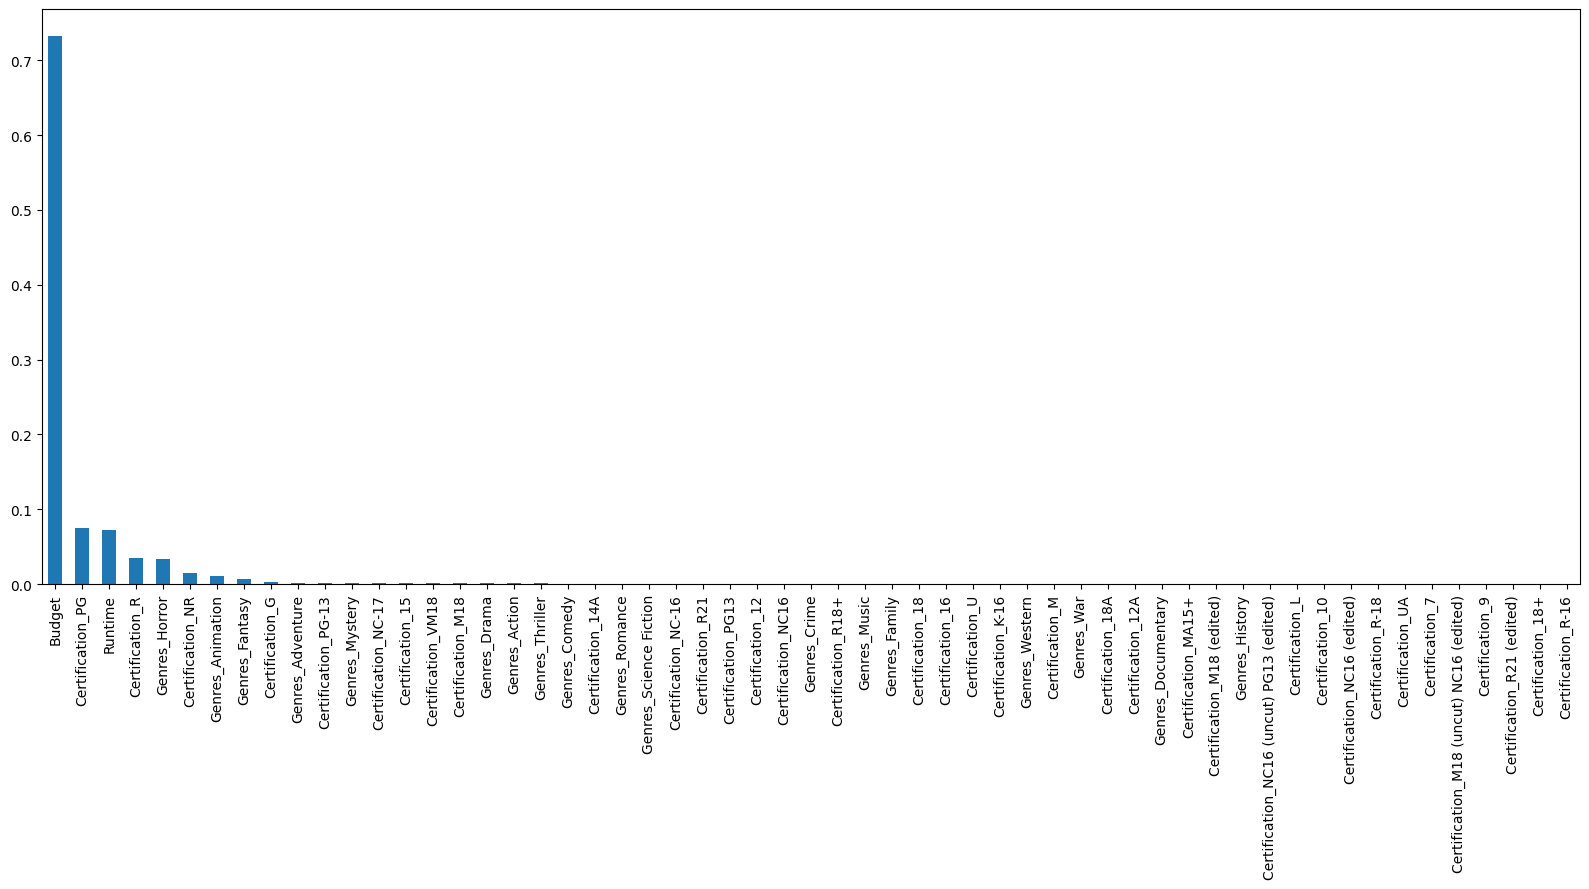

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

X = movies_pd_df_encoded_drop.drop(['Percentage_Profit','Profit', 'Revenue'], axis=1).values  # Features
y = movies_pd_df_encoded_drop['Percentage_Profit'].values  # Target variable

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# Rsquared
r2 = r2_score(y_test, y_pred)
print("Rsquared for 'Percentage_Profit':", r2)

# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE for 'Percentage_Profit':", mse)

# feature importances
importances = model.feature_importances_

# Convert the importances into one dimensional array
f_importances = pd.Series(importances, movies_pd_df_encoded_drop.drop(['Percentage_Profit','Profit', 'Revenue'], axis=1).columns)
f_importances.sort_values(ascending=False, inplace=True)

# plot
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=90)
plt.tight_layout()
plt.show()

# **Third ML Model-removed Revenue, 'Budget', 'Runtime', 'Percentage_Profit' focused on profit**

Rsquared 'Profit': 0.08734701907556641
MSE for 'Profit': 6.254961603986109e+16


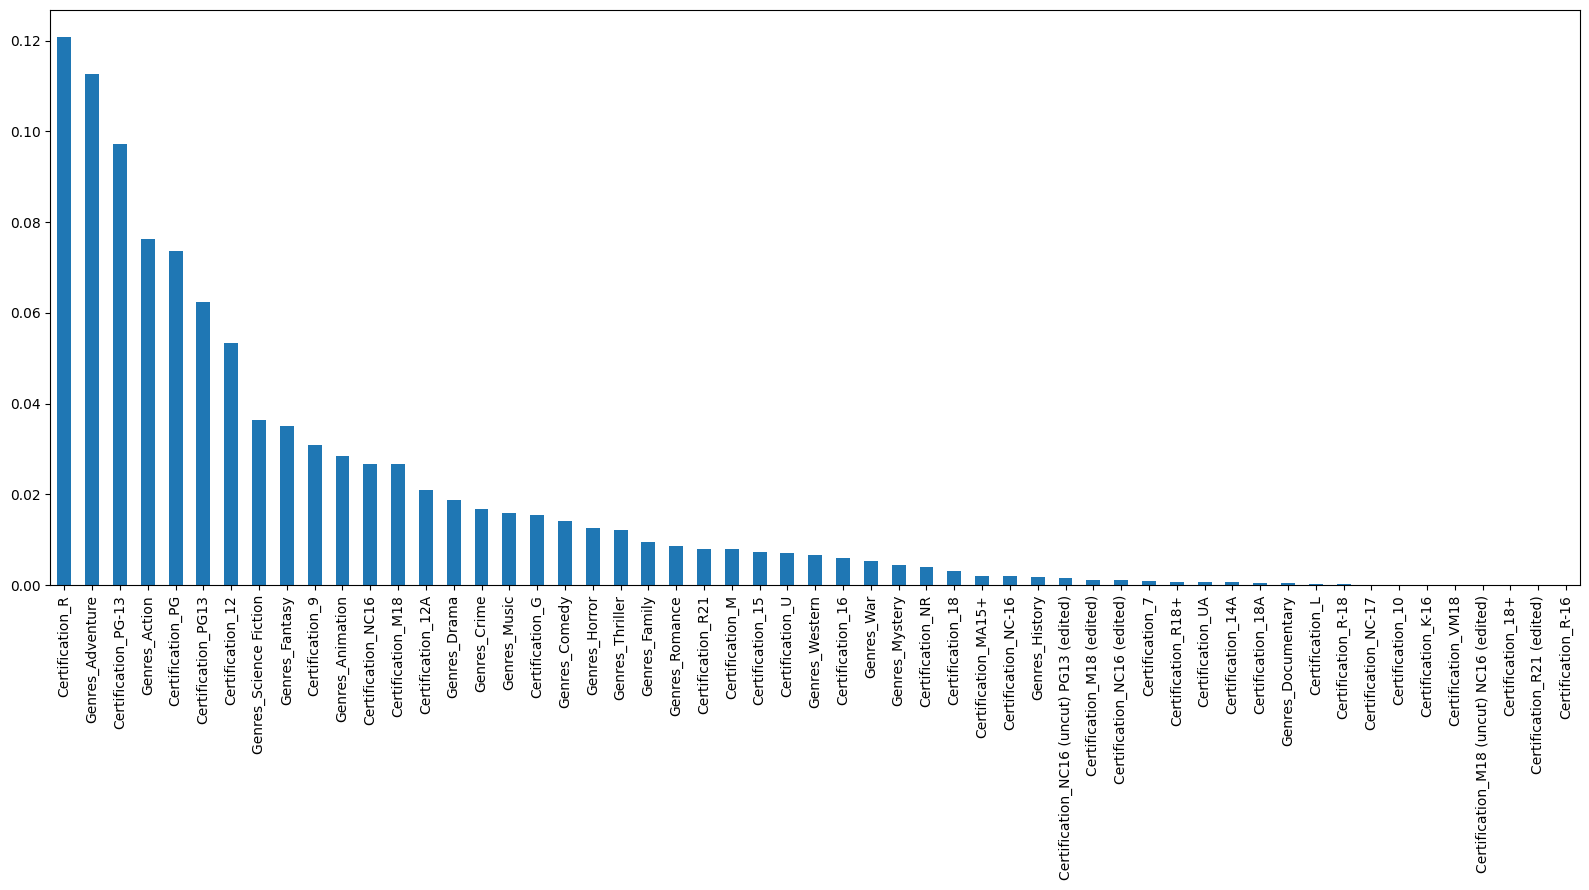

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

X = movies_pd_df_encoded_drop.drop(['Profit', 'Revenue', 'Budget', 'Runtime','Percentage_Profit'], axis=1).values  # Features
y = movies_pd_df_encoded_drop['Profit'].values  # Target variable

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# rsquared
r2 = r2_score(y_test, y_pred)
print("Rsquared 'Profit':", r2)

# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE for 'Profit':", mse)

# feature importances
importances = model.feature_importances_

# Convert the importances into one dimensional array and sort
f_importances = pd.Series(importances, movies_pd_df_encoded_drop.drop(['Profit', 'Revenue', 'Budget', 'Runtime','Percentage_Profit'], axis=1).columns)
f_importances.sort_values(ascending=False, inplace=True)

# plot
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=90)
plt.tight_layout()
plt.show()

# **Testing the accuracy of the dataframe**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = movies_pd_df_encoded_drop.drop('Percentage_Profit', axis=1)
y = (movies_pd_df_encoded_drop['Percentage_Profit'] > 0).astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# logistic regression model
model = LogisticRegression()

# training data
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print
print("Accuracy:", accuracy)

Accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


# **Attempted to optimize our data**

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
# Drop the non-beneficial columns
movies_pd_df_encoded = movies_pd_df_encoded.drop(['Movie_Name','Release_Date','Language'], axis=1)
movies_pd_df_encoded.head()

,Budget,Revenue,Runtime,Profit,Percentage_Profit,Certification_10,Certification_12,Certification_12A,Certification_14A,Certification_15,...,Genres_Fantasy,Genres_History,Genres_Horror,Genres_Music,Genres_Mystery,Genres_Romance,Genres_Science Fiction,Genres_Thriller,Genres_War,Genres_Western
0,250000000,835000000,162,585000000,2.340000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90000000,369105725,103,279105725,3.101175,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12000000,158000000,102,146000000,12.166667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,460000000,2176000000,192,1716000000,3.730435,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,90000000,20000000,139,-70000000,-0.777778,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Split our preprocessed data into our features and target arrays
X = movies_pd_df_encoded.drop("Percentage_Profit", axis=1).values
y = movies_pd_df_encoded["Percentage_Profit"].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
def create_model(hp):
    nn = tf.keras.models.Sequential()

# Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
# First hidden layer
    nn.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=X_train_scaled.shape[1]))
        # step=2), activation=activation, input_dim=2))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn

In [ ]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [ ]:
tuner.search(x=X_train_scaled, y=y_train, epochs=20, validation_data=(X_test_scaled,y_test), batch_size=32)


Trial 60 Complete [00h 00m 07s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 04m 34s


In [ ]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'sigmoid',
 'first_units': 5,
 'num_layers': 5,
 'units_0': 7,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0,
 'units_1': 1,
 'units_2': 1,
 'units_3': 1,
 'units_4': 1}

In [ ]:
# Evaluate the model using the test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

17/17 - 0s - loss: 2.8880 - accuracy: 0.0000e+00 - 275ms/epoch - 16ms/step
Loss: 2.8880233764648438, Accuracy: 0.0


# **Created a new dataframe focused on new movie certifications**

In [ ]:
#Create new data frame droping genres
movies_certification_df = movies_df.toPandas()
movies_certification_df = movies_certification_df.drop(['Genres'], axis=1)
movies_certification_df.head()

,Movie_Name,Certification,Release_Date,Language,Budget,Revenue,Runtime,Profit,Percentage_Profit
0,Black Panther: Wakanda Forever,PG13,11/10/22,English,250000000,835000000,162,585000000,2.340000
1,Puss in Boots: The Last Wish,PG,12/8/22,English,90000000,369105725,103,279105725,3.101175
2,M3GAN,PG13,1/5/23,English,12000000,158000000,102,146000000,12.166667
3,Avatar: The Way of Water,PG13,12/15/22,English,460000000,2176000000,192,1716000000,3.730435
4,Devotion,PG13,1/20/23,English,90000000,20000000,139,-70000000,-0.777778


In [ ]:
# Categorical columns for one-hot encoding
categorical_cols = ['Certification']

# OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)  # 'ignore' handles unknown categories during prediction

#  Transform the categorical columns
encoded_data = encoder.fit_transform(movies_certification_df[categorical_cols])

# DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate encoded features with the original DataFrame
movies_certifications_df_encoded = pd.concat([movies_certification_df, encoded_df], axis=1)

# Drop old columns
movies_certifications_df_encoded = movies_certifications_df_encoded.drop(categorical_cols, axis=1)

# Display the first few rows of the encoded DataFrame
movies_certifications_df_encoded.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Movie_Name,Release_Date,Language,Budget,Revenue,Runtime,Profit,Percentage_Profit,Certification_10,Certification_12,...,Certification_PG13,Certification_R,Certification_R-16,Certification_R-18,Certification_R18+,Certification_R21,Certification_R21 (edited),Certification_U,Certification_UA,Certification_VM18
0,Black Panther: Wakanda Forever,11/10/22,English,250000000,835000000,162,585000000,2.340000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Puss in Boots: The Last Wish,12/8/22,English,90000000,369105725,103,279105725,3.101175,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M3GAN,1/5/23,English,12000000,158000000,102,146000000,12.166667,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Avatar: The Way of Water,12/15/22,English,460000000,2176000000,192,1716000000,3.730435,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Devotion,1/20/23,English,90000000,20000000,139,-70000000,-0.777778,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
movies_cerifitcation_df_encoded_drop = movies_certifications_df_encoded.drop(['Movie_Name','Release_Date', 'Language'], axis=1)
movies_cerifitcation_df_encoded_drop.head()

,Budget,Revenue,Runtime,Profit,Percentage_Profit,Certification_10,Certification_12,Certification_12A,Certification_14A,Certification_15,...,Certification_PG13,Certification_R,Certification_R-16,Certification_R-18,Certification_R18+,Certification_R21,Certification_R21 (edited),Certification_U,Certification_UA,Certification_VM18
0,250000000,835000000,162,585000000,2.340000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90000000,369105725,103,279105725,3.101175,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12000000,158000000,102,146000000,12.166667,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,460000000,2176000000,192,1716000000,3.730435,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90000000,20000000,139,-70000000,-0.777778,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Fourth ML Model-with genre removed from the dataframe**

In [ ]:
X = movies_cerifitcation_df_encoded_drop.drop('Percentage_Profit', axis=1).values
y = movies_cerifitcation_df_encoded_drop.values  # All columns

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(y_train.shape[1])
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict the test set results
y_pred = model.predict(X_test)

# Rsquared
r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')
print("Rsquared:", r2)

# MSE
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("MSE:", mse)

Epoch 1/50
52/52 [==============================] - 1s 5ms/step - loss: 1.0496 - val_loss: 0.9542
Epoch 2/50
52/52 [==============================] - 0s 3ms/step - loss: 0.8828 - val_loss: 0.8652
Epoch 3/50
52/52 [==============================] - 0s 3ms/step - loss: 0.7822 - val_loss: 0.7984
Epoch 4/50
52/52 [==============================] - 0s 3ms/step - loss: 0.6916 - val_loss: 0.7444
Epoch 5/50
52/52 [==============================] - 0s 3ms/step - loss: 0.6182 - val_loss: 0.6981
Epoch 6/50
52/52 [==============================] - 0s 3ms/step - loss: 0.5524 - val_loss: 0.6604
Epoch 7/50
52/52 [==============================] - 0s 2ms/step - loss: 0.4951 - val_loss: 0.6321
Epoch 8/50
52/52 [==============================] - 0s 3ms/step - loss: 0.4470 - val_loss: 0.6090
Epoch 9/50
52/52 [==============================] - 0s 3ms/step - loss: 0.4085 - val_loss: 0.5875
Epoch 10/50
52/52 [==============================] - 0s 3ms/step - loss: 0.3750 - val_loss: 0.5729
Epoch 11/50
52/52 [

# **Fifth ML Model- removed 'Revenue', 'Budget', 'Runtime','Percentage_Profit' columns and focused on profit**

Rsquared 'Profit': 0.04113836023946582
MSE for 'Profit': 5.543787880931776e+16


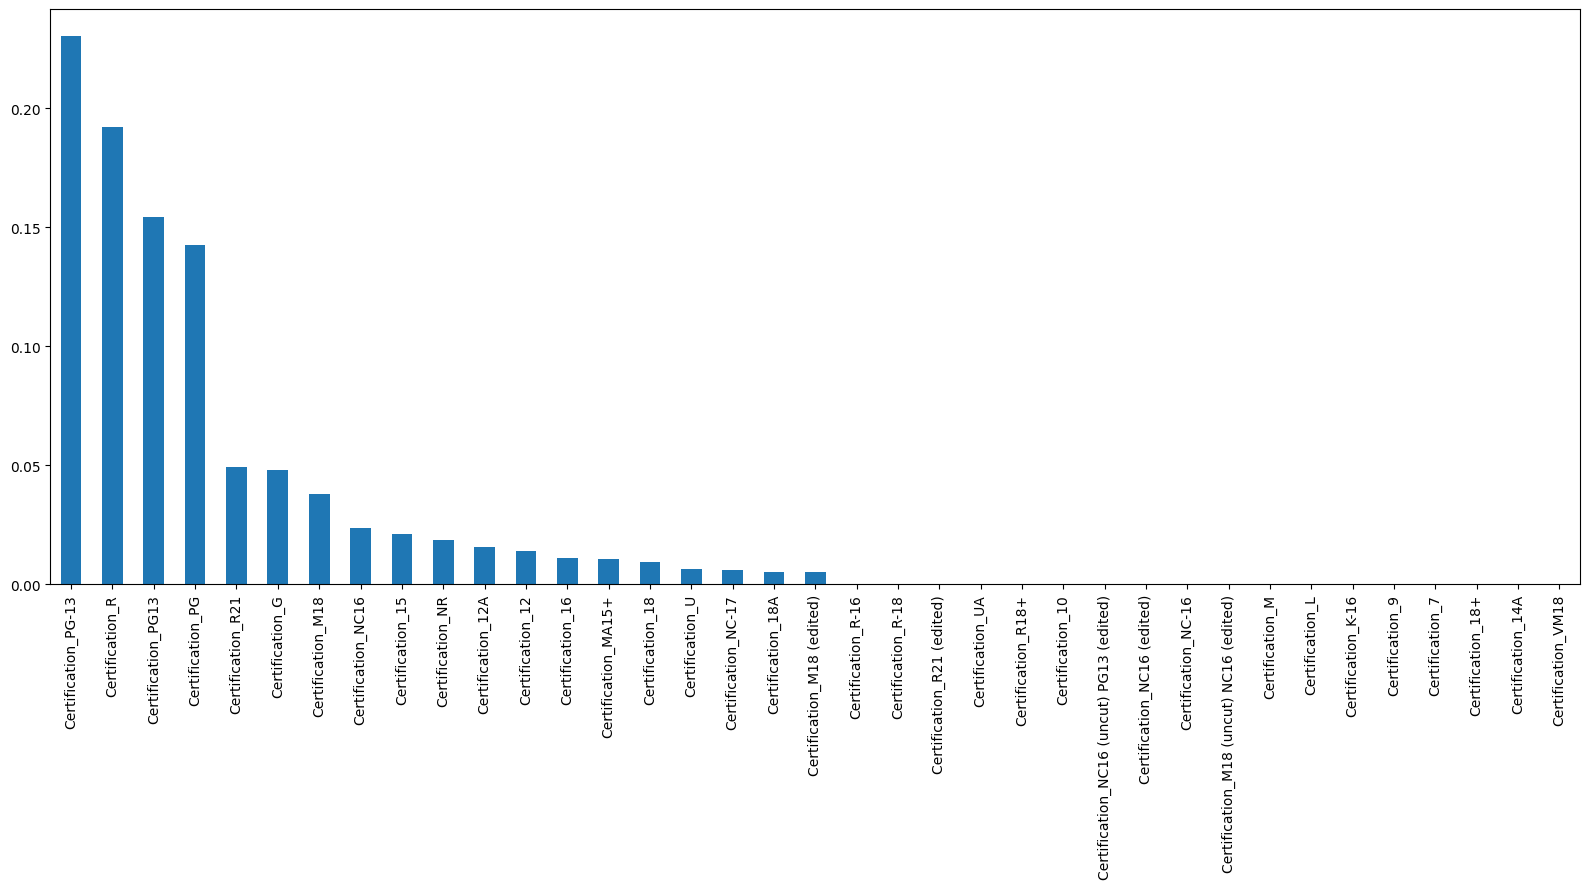

In [ ]:

X = movies_cerifitcation_df_encoded_drop.drop(['Profit', 'Revenue', 'Budget', 'Runtime','Percentage_Profit'], axis=1).values  # Features
y = movies_cerifitcation_df_encoded_drop['Profit'].values  # Target variable

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# rsquared
r2 = r2_score(y_test, y_pred)
print("Rsquared 'Profit':", r2)

# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE for 'Profit':", mse)

# feature importances
importances = model.feature_importances_

# Convert the importances into one dimensional array and sort
f_importances = pd.Series(importances, movies_cerifitcation_df_encoded_drop.drop(['Profit', 'Revenue', 'Budget', 'Runtime','Percentage_Profit'], axis=1).columns)
f_importances.sort_values(ascending=False, inplace=True)

# plot
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=90)
plt.tight_layout()
plt.show()

# **Accuracy testing, 90% of data**

In [ ]:

X = movies_cerifitcation_df_encoded_drop.drop('Percentage_Profit', axis=1)
y = (movies_cerifitcation_df_encoded_drop['Percentage_Profit'] > 0).astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# logistic regression model
model = LogisticRegression()

# training data
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print
print("Accuracy:", accuracy)

Accuracy: 0.9978540772532188


# **Created a new dataframe dropping certifications column**

In [ ]:
#Create new data frame dropping certification
movies_genres_df = movies_df.toPandas()
movies_genres_df = movies_genres_df.drop(['Certification'], axis=1)
movies_genres_df.head()

,Movie_Name,Release_Date,Genres,Language,Budget,Revenue,Runtime,Profit,Percentage_Profit
0,Black Panther: Wakanda Forever,11/10/22,Action,English,250000000,835000000,162,585000000,2.340000
1,Puss in Boots: The Last Wish,12/8/22,Animation,English,90000000,369105725,103,279105725,3.101175
2,M3GAN,1/5/23,Science Fiction,English,12000000,158000000,102,146000000,12.166667
3,Avatar: The Way of Water,12/15/22,Science Fiction,English,460000000,2176000000,192,1716000000,3.730435
4,Devotion,1/20/23,War,English,90000000,20000000,139,-70000000,-0.777778


In [ ]:
# Categorical columns for one-hot encoding
categorical_cols = ['Genres']

# OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)  # 'ignore' handles unknown categories during prediction

#  Transform the categorical columns
encoded_data = encoder.fit_transform(movies_genres_df[categorical_cols])

# DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate encoded features with the original DataFrame
movies_genres_df_encoded = pd.concat([movies_genres_df, encoded_df], axis=1)

# Drop old columns
movies_genres_df_encoded = movies_genres_df_encoded.drop(categorical_cols, axis=1)

# Display the first few rows of the encoded DataFrame
movies_genres_df_encoded.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Movie_Name,Release_Date,Language,Budget,Revenue,Runtime,Profit,Percentage_Profit,Genres_Action,Genres_Adventure,...,Genres_Fantasy,Genres_History,Genres_Horror,Genres_Music,Genres_Mystery,Genres_Romance,Genres_Science Fiction,Genres_Thriller,Genres_War,Genres_Western
0,Black Panther: Wakanda Forever,11/10/22,English,250000000,835000000,162,585000000,2.340000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Puss in Boots: The Last Wish,12/8/22,English,90000000,369105725,103,279105725,3.101175,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M3GAN,1/5/23,English,12000000,158000000,102,146000000,12.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Avatar: The Way of Water,12/15/22,English,460000000,2176000000,192,1716000000,3.730435,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Devotion,1/20/23,English,90000000,20000000,139,-70000000,-0.777778,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
movies_genres_df_encoded_drop = movies_genres_df_encoded.drop(['Movie_Name','Release_Date', 'Language'], axis=1)
movies_genres_df_encoded_drop.head()

,Budget,Revenue,Runtime,Profit,Percentage_Profit,Genres_Action,Genres_Adventure,Genres_Animation,Genres_Comedy,Genres_Crime,...,Genres_Fantasy,Genres_History,Genres_Horror,Genres_Music,Genres_Mystery,Genres_Romance,Genres_Science Fiction,Genres_Thriller,Genres_War,Genres_Western
0,250000000,835000000,162,585000000,2.340000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90000000,369105725,103,279105725,3.101175,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12000000,158000000,102,146000000,12.166667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,460000000,2176000000,192,1716000000,3.730435,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,90000000,20000000,139,-70000000,-0.777778,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# **Sixth ML Model- remove certifications column**

In [ ]:
X = movies_genres_df_encoded_drop.drop('Percentage_Profit', axis=1).values
y = movies_genres_df_encoded_drop.values  # All columns

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(y_train.shape[1])
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict the test set results
y_pred = model.predict(X_test)

# Rsquared
r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')
print("Rsquared:", r2)

# MSE
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("MSE:", mse)

Epoch 1/50
7/7 [==============================] - 1s 49ms/step - loss: 1.2360 - val_loss: 1.1330
Epoch 2/50
7/7 [==============================] - 0s 30ms/step - loss: 1.0934 - val_loss: 1.0459
Epoch 3/50
7/7 [==============================] - 0s 30ms/step - loss: 1.0055 - val_loss: 0.9843
Epoch 4/50
7/7 [==============================] - 0s 30ms/step - loss: 0.9419 - val_loss: 0.9364
Epoch 5/50
7/7 [==============================] - 0s 31ms/step - loss: 0.8851 - val_loss: 0.8957
Epoch 6/50
7/7 [==============================] - 0s 29ms/step - loss: 0.8347 - val_loss: 0.8597
Epoch 7/50
7/7 [==============================] - 0s 30ms/step - loss: 0.7906 - val_loss: 0.8247
Epoch 8/50
7/7 [==============================] - 0s 31ms/step - loss: 0.7470 - val_loss: 0.7905
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 0.7031 - val_loss: 0.7557
Epoch 10/50
7/7 [==============================] - 0s 19ms/step - loss: 0.6598 - val_loss: 0.7200
Epoch 11/50
7/7 [============

# **Seventh ML Model- removed 'Revenue', 'Budget', 'Runtime','Percentage_Profit column**

Rsquared 'Profit': 0.029872254195874692
MSE for 'Profit': 5.6089243923531224e+16


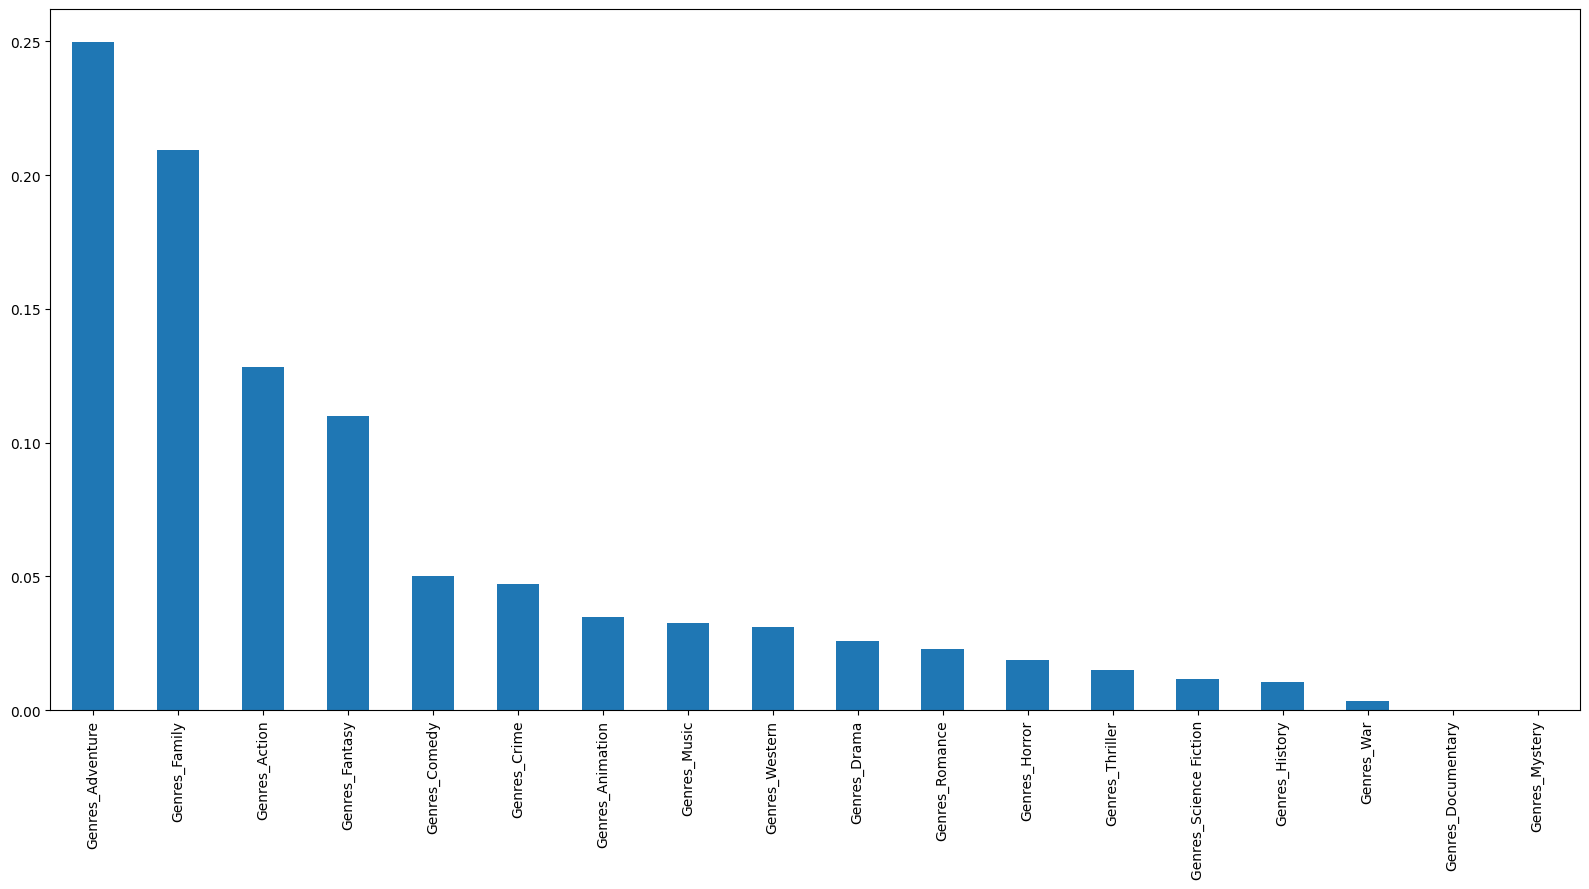

In [ ]:

X = movies_genres_df_encoded_drop.drop(['Profit', 'Revenue', 'Budget', 'Runtime','Percentage_Profit'], axis=1).values  # Features
y = movies_genres_df_encoded_drop['Profit'].values  # Target variable

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# rsquared
r2 = r2_score(y_test, y_pred)
print("Rsquared 'Profit':", r2)

# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE for 'Profit':", mse)

# feature importances
importances = model.feature_importances_

# Convert the importances into one dimensional array and sort
f_importances = pd.Series(importances, movies_genres_df_encoded_drop.drop(['Profit', 'Revenue', 'Budget', 'Runtime','Percentage_Profit'], axis=1).columns)
f_importances.sort_values(ascending=False, inplace=True)

# plot
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=90)
plt.tight_layout()
plt.show()

# **Testing accuracy of the new dataframe without certifications, 90% of the data used**

In [ ]:
X = movies_genres_df_encoded_drop.drop('Percentage_Profit', axis=1)
y = (movies_genres_df_encoded_drop['Percentage_Profit'] > 0).astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# logistic regression model
model = LogisticRegression()

# training data
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print
print("Accuracy:", accuracy)

Accuracy: 0.9978540772532188
